In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression

In [2]:
# Cell 1: Define Custom Transformers

class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[[self.key]]

class BoolSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[[self.key]].astype(float)
    
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key, dtype=None):
        self.key = key
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.dtype:
            return X[[self.key]].astype(self.dtype)
        return X[[self.key]]


In [3]:
pd.set_option('display.max_columns', None)


In [4]:
dataset = pd.read_pickle('train.pkl')
dataset.head()

,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance,segmentsDepartureTimeEpochSeconds,segmentsDepartureTimeRaw,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode,days_until_flight,days_since_last_search,fare_change,seats_change,weighted_fare_change,weighted_seats_change,is_search_weekend,is_flight_weekend,Multiple_Carriers,distinct_airlines,combination_code,journeyStartTime,searchDayName,flightDayName,searchDay,flightDay
84572,20dc57dc714100c3acf0fc3400df937c,2022-06-24,2022-06-25,SFO,LGA,MA0QA0MQ,PT12H19M,1.0,0,0,0,714.42,797.2,2.0,2897.0,1656217800||1656253800,2022-06-25T21:30:00.000-07:00||2022-06-26T10:3...,1656234540||1656262140,2022-06-26T05:09:00.000-04:00||2022-06-26T12:4...,ATL||LGA,SFO||ATL,Delta||Delta,DL||DL,Boeing 737-900||Airbus A320,16740||8340,2135||762,coach||coach,1,9.0,44.0,-7.0,4.888889,-0.777778,0,1,0,{Delta},4,21.500000,Friday,Saturday,4,5
21171,1eb522898e3c567b7d62a9d8d7e61152,2022-05-08,2022-06-23,SFO,BOS,UAA0OHEN,PT5H37M,1.0,0,0,1,524.65,578.6,9.0,2698.0,1656046020,2022-06-23T21:47:00.000-07:00,1656066240,2022-06-24T06:24:00.000-04:00,BOS,SFO,United,UA,Boeing 737 MAX 9,20220,2698,coach,46,1.0,0.0,0.0,0.000000,0.000000,1,0,0,{United},10,21.783333,Sunday,Thursday,6,3
47459,86f3b8bf39cfea9b09a0e46fa75d6e16,2022-07-06,2022-07-31,SFO,EWR,KH0OASMN,PT5H50M,0.0,0,0,1,478.14,528.6,7.0,2566.0,1659291000,2022-07-31T11:10:00.000-07:00,1659312000,2022-07-31T20:00:00.000-04:00,EWR,SFO,Alaska Airlines,AS,Boeing 737-900,21000,2566,coach,25,1.0,-100.0,0.0,-100.000000,0.000000,0,1,0,{Alaska Airlines},1,11.166667,Wednesday,Sunday,2,6
106870,e0eb783f205cbc64edaa1f186ada7bba,2022-08-24,2022-09-17,SFO,CLT,SAA2AFEN,PT10H21M,0.0,0,0,0,188.84,226.6,9.0,3111.0,1663423200||1663452840,2022-09-17T07:00:00.000-07:00||2022-09-17T18:1...,1663442460||1663460460,2022-09-17T15:21:00.000-04:00||2022-09-17T20:2...,EWR||CLT,SFO||EWR,United||United,UA||UA,BOEING 777-300ER||Boeing 737-900,19260||7620,2566||545,coach||coach,24,1.0,0.0,0.0,0.000000,0.000000,0,1,0,{United},10,7.000000,Wednesday,Saturday,2,5
51925,65e124bd8ce6db3fafbf41c3f554caef,2022-04-26,2022-05-06,SFO,ORD,VAA7OKEN,PT4H15M,1.0,0,0,1,282.79,318.6,1.0,1847.0,1651886700,2022-05-06T18:25:00.000-07:00,1651902000,2022-05-07T00:40:00.000-05:00,ORD,SFO,United,UA,Boeing 737-900,15300,1847,coach,10,1.0,-24.0,-8.0,-24.000000,-8.000000,0,0,0,{United},10,18.416667,Tuesday,Friday,1,4


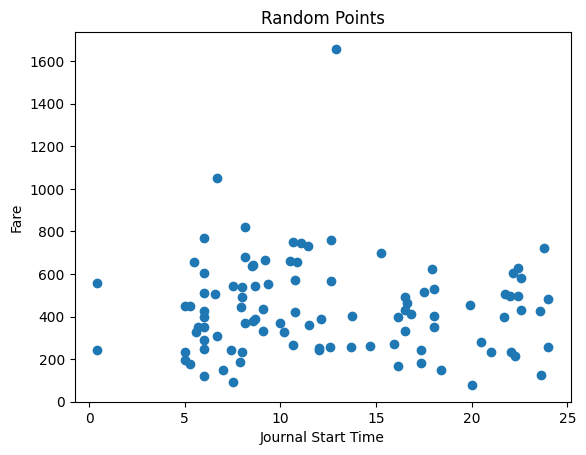

In [5]:
import matplotlib.pyplot as plt

# Select random points from the dataset
random_points = dataset.sample(n=100)

# Plot the graph
plt.scatter(random_points['journeyStartTime'], random_points['totalFare'])
plt.xlabel('Journal Start Time')
plt.ylabel('Fare')
plt.title('Random Points')
plt.show()


In [6]:
dataset = pd.read_pickle('train.pkl')
dataset["distinct_airlines"] = dataset["distinct_airlines"].apply(lambda x: list(x)[0] if x and isinstance(x, set) else None)


In [7]:
test_dataset = pd.read_pickle('test.pkl')
test_dataset["distinct_airlines"] = test_dataset["distinct_airlines"].apply(lambda x: list(x)[0] if x and isinstance(x, set) else None)


In [8]:
features1 = ['flightDayName', 'searchDayName', 'destinationAirport', 'distinct_airlines', 'is_search_weekend', 'is_flight_weekend', 'days_until_flight', 'isBasicEconomy']
categorical_tbe = ['isNonStop', 'Multiple_Carriers']
numerical_tbe = ['baseFare', 'totalTravelDistance', 'elapsedDays']

features = features1 + categorical_tbe + numerical_tbe

target = "totalFare"
X_train = dataset[features]
y_train = dataset[target]

X_test = test_dataset[features]
y_test = test_dataset[target]

In [9]:
X_train.dtypes

flightDayName           object
searchDayName           object
destinationAirport      object
distinct_airlines       object
is_search_weekend        int64
is_flight_weekend        int64
days_until_flight        int64
isBasicEconomy           int64
isNonStop                int64
Multiple_Carriers        int64
baseFare               float64
totalTravelDistance    float64
elapsedDays            float64
dtype: object

In [10]:
# Pipeline Setup for Each Feature
days_until_flight_pipe = Pipeline([
    ('selector', ColumnSelector(key='days_until_flight')),
    ('standard', StandardScaler())
])

is_search_weekend_pipe = Pipeline([
    ('selector', ColumnSelector(key='is_search_weekend')),
    ('standard', StandardScaler())
])

is_flight_weekend_pipe = Pipeline([
    ('selector', ColumnSelector(key='is_flight_weekend')),
    ('standard', StandardScaler())
])

search_day_pipe = Pipeline([
    ('selector', ColumnSelector(key='searchDayName')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

flight_day_pipe = Pipeline([
    ('selector', ColumnSelector(key='flightDayName')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

is_basic_economy_pipe = Pipeline([
    ('selector', ColumnSelector(key='isBasicEconomy')),
    ('standard', StandardScaler())
])

distinct_airlines_pipiline = Pipeline([
    ('selector', ColumnSelector(key='distinct_airlines', dtype='str')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

destination_airport_pipe = Pipeline([
    ('selector', ColumnSelector(key='destinationAirport', dtype='str')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

baseFare_pipe = Pipeline([
    ('selector', NumberSelector(key='baseFare')),
    ('standard', StandardScaler())
])

totalTravelDistance_pipe = Pipeline([
    ('selector', NumberSelector(key='totalTravelDistance')),
    ('standard', StandardScaler())
])

elapsedDays_pipe = Pipeline([
    ('selector', NumberSelector(key='elapsedDays')),
    ('standard', StandardScaler())
])

isNonStop_pipe = Pipeline([
    ('selector', BoolSelector(key='isNonStop')),
    ('standard', StandardScaler())
])

Multiple_Carriers_pipe = Pipeline([
    ('selector', BoolSelector(key='Multiple_Carriers')),
    ('standard', StandardScaler())
])




# Combine Features Using FeatureUnion
combined_features = FeatureUnion([
    ('days_until_flight', days_until_flight_pipe),
    ('is_search_weekend', is_search_weekend_pipe),
    ('is_flight_weekend', is_flight_weekend_pipe),
    ('search_day', search_day_pipe),
    ('flight_day', flight_day_pipe),
    ('is_basic_economy', is_basic_economy_pipe),
    ('distinct_airlines', distinct_airlines_pipiline),
    ('destination_airport', destination_airport_pipe),
    ('baseFare', baseFare_pipe),
    ('totalTravelDistance', totalTravelDistance_pipe),
    ('elapsedDays', elapsedDays_pipe),
    ('isNonStop', isNonStop_pipe),
    ('Multiple_Carriers', Multiple_Carriers_pipe)
])

# Final Pipeline with Regression
pipeline = Pipeline([
    ('features', combined_features),
    ('regressor', LinearRegression())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("Predicted fares:", y_pred[:10])


Predicted fares: [428.53846063 812.74387051 158.59119578 268.18581768 803.96373522
 437.7199993  554.9947952  232.52726889 369.63584723 543.32080439]


In [11]:
y_test[:10]

128169    428.60
28053     810.60
104331    158.60
19892     266.60
45944     802.60
44434     436.60
82794     553.59
88110     232.60
92390     372.20
88012     543.60
Name: totalFare, dtype: float64

In [15]:
X_test.columns

Index(['flightDayName', 'searchDayName', 'destinationAirport',
       'distinct_airlines', 'is_search_weekend', 'is_flight_weekend',
       'days_until_flight', 'isBasicEconomy', 'isNonStop', 'Multiple_Carriers',
       'baseFare', 'totalTravelDistance', 'elapsedDays'],
      dtype='object')

In [12]:
import joblib

# Assuming 'pipeline' is your trained model
joblib.dump(pipeline, 'flight_fare_predictor.pkl')


['flight_fare_predictor.pkl']

## Pre - Model: Estimator

- 'destinationAirport'                        G
- 'travelDuration',                           E
- 'elapsedDays',                              E
- 'isBasicEconomy',                           G
- 'isRefundable',                             D
- 'isNonStop',                                E
- 'baseFare',                                 E
- 'totalFare',                                T
- 'seatsRemaining',                           E
- 'totalTravelDistance',                      E
- 'segmentsDepartureTimeEpochSeconds',        D
- 'segmentsDepartureTimeRaw',                 D
- 'segmentsArrivalTimeEpochSeconds',          D
- 'segmentsArrivalTimeRaw',                   D
- 'segmentsArrivalAirportCode',               D
- 'segmentsDepartureAirportCode',             D
- 'segmentsAirlineName',                      G
- 'segmentsAirlineCode',                      D
- 'segmentsEquipmentDescription',             D
- 'segmentsDurationInSeconds',                D
- 'segmentsDistance',                         D
- 'segmentsCabinCode',                        D
- 'days_until_flight',                        G
- 'days_since_last_search',                   -
- 'fare_change',                              -
- 'seats_change',                             -
- 'weighted_fare_change',                     -
- 'weighted_seats_change',                    -
- 'is_search_weekend',                        G   
- 'is_flight_weekend',                        G
- 'Multiple_Carriers',                        E
- 'distinct_airlines',                        D
- 'combination_code',                         E
- 'journeyStartTime',                         E
- 'searchDayName',                            G
- 'flightDayName',                            G
- 'searchDay',                                G
- 'flightDay']                                G

In [ ]:
dataset = pd.read_pickle('processed.pkl')
dataset.head()

In [ ]:
pre_targets = ["elapsedDays", "isNonStop", "baseFare", "seatsRemaining", "totalTravelDistance", "Multiple_Carriers", "combination_code"]
features = ["isBasicEconomy", "days_until_flight", "is_search_weekend", "is_flight_weekend", "searchDayName", "flightDayName", "segmentsAirlineName", "destinationAirport"]

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier

In [ ]:
features = ["isBasicEconomy", "days_until_flight", "is_search_weekend", "is_flight_weekend", "searchDayName", "flightDayName", "segmentsAirlineName", "destinationAirport"]
regression_targets = ["elapsedDays", "baseFare", "seatsRemaining", "totalTravelDistance", "combination_code"]
classification_targets = ["isNonStop", "Multiple_Carriers"]

In [ ]:
X = dataset[features]
y = dataset[regression_targets + classification_targets]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Separate y_train for regression and classification
y_train_regress = y_train[regression_targets]
y_train_classify = y_train[classification_targets]

# Feature preprocessing for numeric and categorical data
numeric_features = ['days_until_flight']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_features = ['isBasicEconomy', 'is_search_weekend', 'is_flight_weekend', 'searchDayName', 'flightDayName', 'segmentsAirlineName', 'destinationAirport']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [ ]:
# Multi-output regression model
regression_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', MultiOutputRegressor(RandomForestRegressor(n_estimators=100)))
])

# Multi-output classification model
classification_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MultiOutputClassifier(RandomForestClassifier(n_estimators=100)))
])

# Fit the models
regression_pipeline.fit(X_train, y_train_regress)
classification_pipeline.fit(X_train, y_train_classify)

In [ ]:
y_pred_regress = regression_pipeline.predict(X_test)
y_pred_classify = classification_pipeline.predict(X_test)

# Optionally, you can merge these predictions back to a DataFrame and compare or use further
predicted_regress_df = pd.DataFrame(y_pred_regress, columns=regression_targets, index=X_test.index)
predicted_classify_df = pd.DataFrame(y_pred_classify, columns=classification_targets, index=X_test.index)
predictions_df = pd.concat([predicted_regress_df, predicted_classify_df], axis=1)
print(predictions_df.head())